# Lesson 1: Practical Deep Learning for Coders

This notebooks presents my personal notes and work coming from the experience with the fastbook and the related course from fast.ai ([here](https://www.youtube.com/watch?v=8SF_h3xF3cE) for video on YT). The lecture is based on the first chapter fo the book. 
Related material used in the lecture:
- Is it a bird? Creating a model from your own data ([Kaggle notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data))

In [1]:
# Install the necessary packages
# !pip install duckduckgo-search==4.1.1
# !pip install fastai==2.7.13
# !pip install fastcore==1.5.29
# !pip install fastdownload==0.0.7

## Is it a bird?

Jeremy kicks off his first lecture by diving straight into a cool example of deep learning, making the course hands-on right from the get-go. From his book "The basic idea is to teach the whole game. That means that if you're teaching baseball, you first take people to a baseball game or get them to play it. You don't teach them how to wind twine to make a baseball from scratch, the physics of a parabola, or the coefficient of friction of a ball on a bat."

Basically, he wants to highlight that back in 2015, the idea of making a computer recognize birds was so tricky that it became the punchline of an XKCD joke, shown here:

<div style="text-align:center">
<img src="./images/tasks_2x.png" width="200" height="100">
</div>
But guess what? Nowadays, we can pull off that same bird recognition magic in just a few minutes using totally free resources! In the world of CS, it's often hard to tell what's a walk in the park and what's nearly impossible. What seemed like a big challenge in 2015 can now be done with a few lines of code, and this lesson spills the beans on why and how it became possible.

The basic steps are:

1. Use DuckDuckGo to search for images of "bird photos";
2. Use DuckDuckGo to search for images of "forest photos", as a representative of not-bird photos;
3. Fine-tune a pretrained neural network to recognise these two groups;
4. Try running this model on a picture of a bird and see if it works.

### Step 1: Download images of birds and non-bird

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import L

def search_images(term, max_images=30):
    # Define a function to download from ddg a max of max_images with the keyword term
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


C:\Users\conti\Progetti\agile-lab\books\fastbook\.venv\lib\site-packages\duckduckgo_search\compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://images.pexels.com/photos/1661179/pexels-photo-1661179.jpeg?cs=srgb&dl=green-bird-1661179.jpg&fm=jpg'

...and then download a URL and take a look at it:

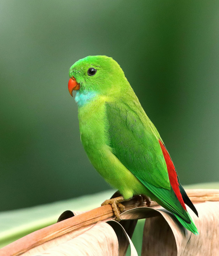

In [4]:
# download the image and save it in the dest provided
from fastdownload import download_url
dest = r'.\images\bird.jpg'
download_url(urls[0], dest, show_progress=False)

# load the image in the Image object from fastai.vision and show it
from fastai.vision.all import Image
im = Image.open(dest)
im.to_thumb(256,256)

As you may already know, a digital image consists of pixel with numerical value encoding colours or intensity, depending on the encoding technic adopted. You can practice with this concept with the web-app [PixSpy](https://pixspy.com/) as reported in the following image:

<div style="text-align:center">
<img src="./images/pixspy.PNG"  width="500" height="250">
</div>


As it could be hard to search for "not bird images" on a search engine, to get image in this example Jeremy is going to take images of forest. Hence, the following example is building a "bird/forest" classifier.
So let's do the same with "forest photos":

Searching for 'forest photos'


C:\Users\conti\Progetti\agile-lab\books\fastbook\.venv\lib\site-packages\duckduckgo_search\compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


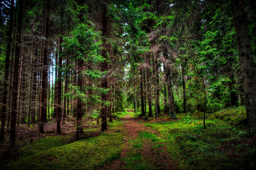

In [5]:
# download a forest image and show it
download_url(search_images('forest photos', max_images=1)[0], r'.\images\forest.jpg', show_progress=False)
Image.open(r'.\images\forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
from time import sleep
from pathlib import Path
from fastai.vision.all import download_images, resize_images
searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [10]:
from fastai.vision.all import verify_images, get_image_files
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

### Step 2: Train our model

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model, not used during training).

In fastai you can create that easily using a DataBlock, and view sample images from it:

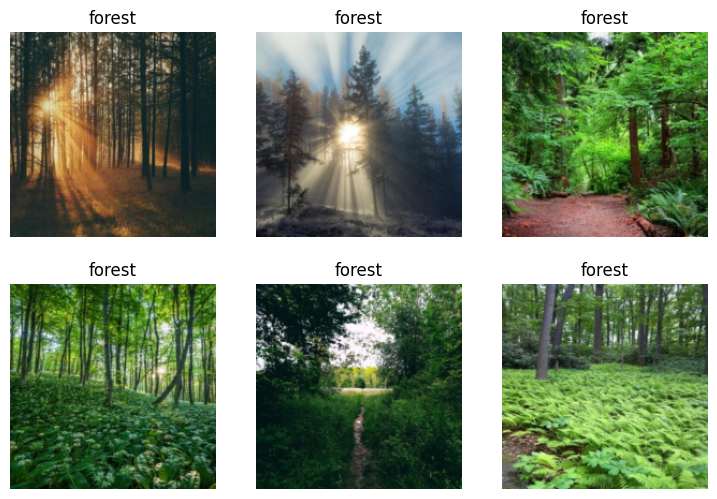

In [16]:
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label,Resize

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the DataBlock parameters means:
```
blocks=(ImageBlock, CategoryBlock),
```
The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").
```
get_items=get_image_files, 
```
To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).
```
splitter=RandomSplitter(valid_pct=0.2, seed=42),
```
Split the data into training and validation sets randomly, using 20% of the data for the validation set.
```
get_y=parent_label,
```
The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).
```
item_tfms=[Resize(192, method='squish')]
```
Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is resnet18. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.
XXXXXXXXXX talk about the vision_learner a model and data.........
Model family named resnet....
timm image model...
https://github.com/fastai/timmdocs/tree/master/

Downloading resnet18 weight (trained on ImageNet) online available 
fine-tune is a form of transfer learning

In [18]:
from fastai.vision.all import vision_learner, resnet18, error_rate
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\conti/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:12<00:00, 3.79MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.836780,0.502131,0.220000,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.133102,0.064978,0.020000,00:46
1,0.083131,0.007272,0.000000,00:47
2,0.058540,0.012661,0.000000,00:50


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories).


### Step 3: Use our model (and build your own!)

Deploy....
Let's see what our model thinks about that bird we downloaded at the start:

In [22]:
from fastai.vision.all import PILImage
is_bird,_,probs = learn.predict(PILImage.create(r'.\images\bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"! All on your personal computer!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including creating amazing artworks, and explaining jokes. It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behin

### XXXXXXXXXXXXXX

Why are we able to build a bird recognizer in a minute?
How it was done before? In 2012, image recognition with classic Machine-Learning (pre-deep learning) required a deep knownedge of Computer Science, Mathematics, Pathology.... time, expertise, a lot of code, people to build features

Neural Netowrks build features automatically for us.. deep because it combines this kind of features....

Image-base approach for other tasks:
- Classify sounds: picture from sounds using spectogram
- Classify time-series using image
- Pictures from mouse mouvements (Splunk module)
- 

## What can deep learning do now?
- Image generation: from text input (DALL-E 2, midjourney);
- LLM: ChatGPT, language models can already explain jokes;
In this course you can get the practical basis to understand and work with this system!

Here's a list of some of the thousands of tasks in different areas at which deep learning, or methods heavily using deep learning, is now the best in the world:

Natural language processing (NLP):: Answering questions; speech recognition; summarizing documents; classifying documents; finding names, dates, etc. in documents; searching for articles mentioning a concept
Computer vision:: Satellite and drone imagery interpretation (e.g., for disaster resilience); face recognition; image captioning; reading traffic signs; locating pedestrians and vehicles in autonomous vehicles
Medicine:: Finding anomalies in radiology images, including CT, MRI, and X-ray images; counting features in pathology slides; measuring features in ultrasounds; diagnosing diabetic retinopathy
Biology:: Folding proteins; classifying proteins; many genomics tasks, such as tumor-normal sequencing and classifying clinically actionable genetic mutations; cell classification; analyzing protein/protein interactions
Image generation:: Colorizing images; increasing image resolution; removing noise from images; converting images to art in the style of famous artists
Recommendation systems:: Web search; product recommendations; home page layout
Playing games:: Chess, Go, most Atari video games, and many real-time strategy games
Robotics:: Handling objects that are challenging to locate (e.g., transparent, shiny, lacking texture) or hard to pick up
Other applications:: Financial and logistical forecasting, text to speech, and much more...

## How to learn?

Learning with context- top-down approach
people learn naturally (better) with context rather than by theoretical curriculum
So, here's our commitment to you. Throughout this book, we will follow these principles:

- 
Teaching the whole game. We'll start by showing how to use a complete, working, very usable, state-of-the-art deep learning network to solve real-world problems, using simple, expressive tools. And then we'll gradually dig deeper and deeper into understanding how those tools are made, and how the tools that make those tools are made, and so o…- 
Always teaching through examples. We'll ensure that there is a context and a purpose that you can understand intuitively, rather than starting with algebraic symbol manipulat- n- .
Simplifying as much as possible. We've spent years building tools and teaching methods that make previously complex topics very sp- l- e.
Removing barriers. Deep learning has, until now, been a very exclusive game. We're breaking it open, and ensuring that everyone can play.


Do we need a lot of maths, a lot of data and a lot of computer resources? No! Real world problems can be dealt with few resources. 

| Myth (don't need) | Truth |
|---|---|
| Lots of math | Just high school math is sufficient |
| Lots of data | We've seen record-breaking results with <50 items of data |
| Lots of expensive computers | You can get what you need for state-of-the-art work for les|====

You can do real state-of-the-art work on Kaggle or Google Colab

### Why fastai and why pytorch?

pytorch vs tensorflow....
why fastai (built on top of pytorch)?
Pytorch is designed to be a strong fundation to built on top 
The more code, the more mistakes, less best-practice, difficult to mantain, expecially in deep-learning
fastai uses best-practice for us.. really popular in industry

## Not just image recognition

segmentation....
fit_one_cycle, not pre-trained

tabular data

collaborative filters, reccomandation systems

collab-learner

## CS vs ML: graphs

## Homeworks